# 1. Import Required Libraries

In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import xgboost as xgb  # ML algorithm for forecasting
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error  # Error metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.stats import spearmanr, chi2_contingency

In [7]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=2)
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 3, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [8]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

# 2. Load the Data

In [9]:
df = pd.read_csv("../dataset/common_diseases.csv")

In [10]:
df.head()

,Date,Disease,Frequency,Average Age,StdDev Age,Subdistrict
0,2015-01-06,J18.0,1,10.0,0.0,5
1,2015-01-12,J18.0,1,6.0,0.0,5
2,2015-01-19,J18.0,1,1.0,0.0,4
3,2015-01-23,J18.0,1,3.0,0.0,2
4,2015-01-26,J18.0,1,56.0,0.0,3


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24672 entries, 0 to 24671
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         24672 non-null  object 
 1   Disease      24672 non-null  object 
 2   Frequency    24672 non-null  int64  
 3   Average Age  24672 non-null  float64
 4   StdDev Age   24672 non-null  float64
 5   Subdistrict  24672 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [12]:
print('dataset ini mengandung {} baris dan {} kolom'. format(df.shape[0], df.shape[1]))

dataset ini mengandung 24672 baris dan 6 kolom


# 3. Data Cleaning

Mengubah format date menjadi datetime 

In [13]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

Mengambil penyakit tertentu yaitu I10 untuk diproses lebih lanjut

In [14]:
df_D64 = df[df["Disease"] == "D64.9"]

uniform_index = pd.date_range(start=df_D64.index.min(), end=df_D64.index.max(), freq="D")
df_D64 = df_D64.reindex(uniform_index)
df_D64.index.name = "Date"

df_D64

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-05,D64.9,1.0,57.0,0.0,1.0
2015-01-06,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN
2015-01-08,D64.9,1.0,2.0,0.0,6.0
2015-01-09,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-12-20,D64.9,2.0,32.0,14.0,2.0
2024-12-21,NaN,NaN,NaN,NaN,NaN
2024-12-22,NaN,NaN,NaN,NaN,NaN


In [15]:
# cek apakah ada nilai null (kosong atau NaN)
print(df_D64.isnull().sum())

Disease        1880
Frequency      1880
Average Age    1880
StdDev Age     1880
Subdistrict    1880
dtype: int64


Ada 1565 data yang NaN dikarenakan beberapa tanggal hilang saat preprocessing data.

In [16]:
df_D64.describe()

,Frequency,Average Age,StdDev Age,Subdistrict
count,1762.000000,1762.000000,1762.000000,1762.000000
mean,1.830874,46.178395,6.198765,3.974461
std,1.304254,19.094653,8.993248,1.653700
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,36.000000,0.000000,3.000000
50%,1.000000,49.000000,0.000000,4.000000
75%,2.000000,59.500000,11.000000,5.000000
max,11.000000,93.000000,44.500000,7.000000


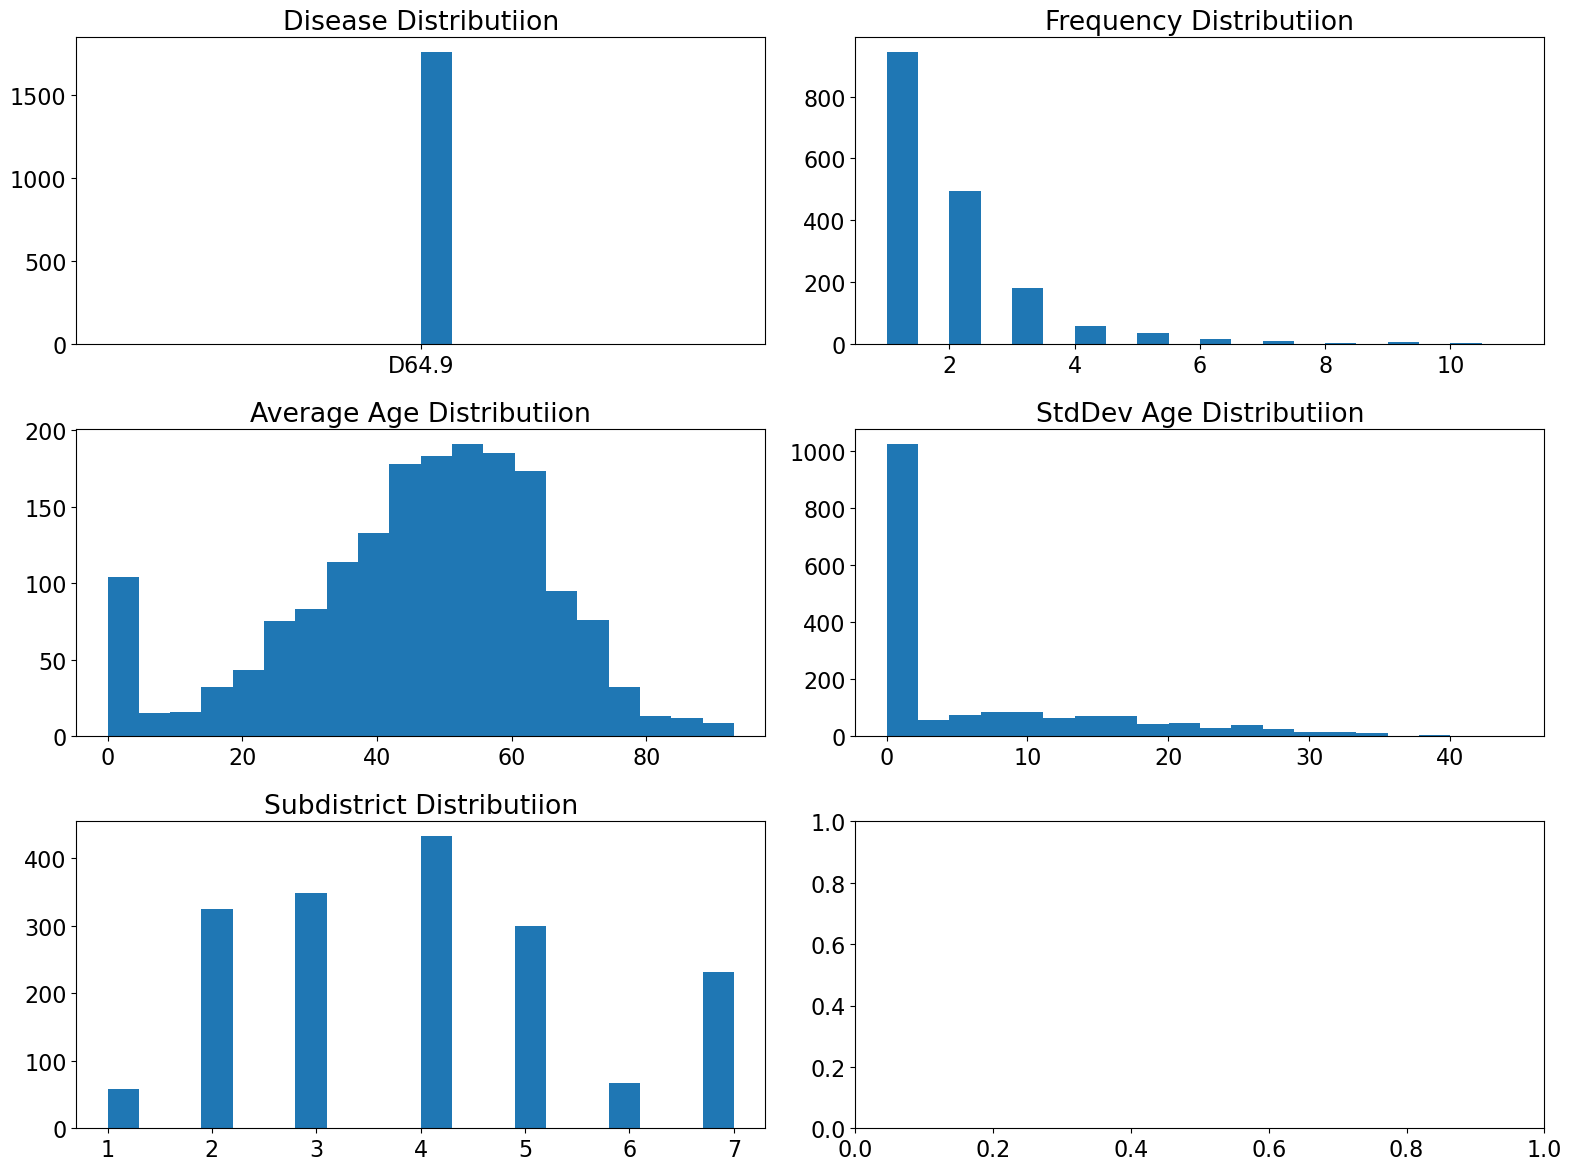

In [17]:
# df_E11 = df_E11.apply(pd.to_numeric, errors='coerce')

fig, axs = plt.subplots(3,2, figsize = (16,12))
axs = axs.ravel()

for i, column in enumerate(df_D64.columns):
    axs[i].hist(df_D64[column].dropna(), bins = 20)
    axs[i].set_title('{} Distributiion'.format(column))

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

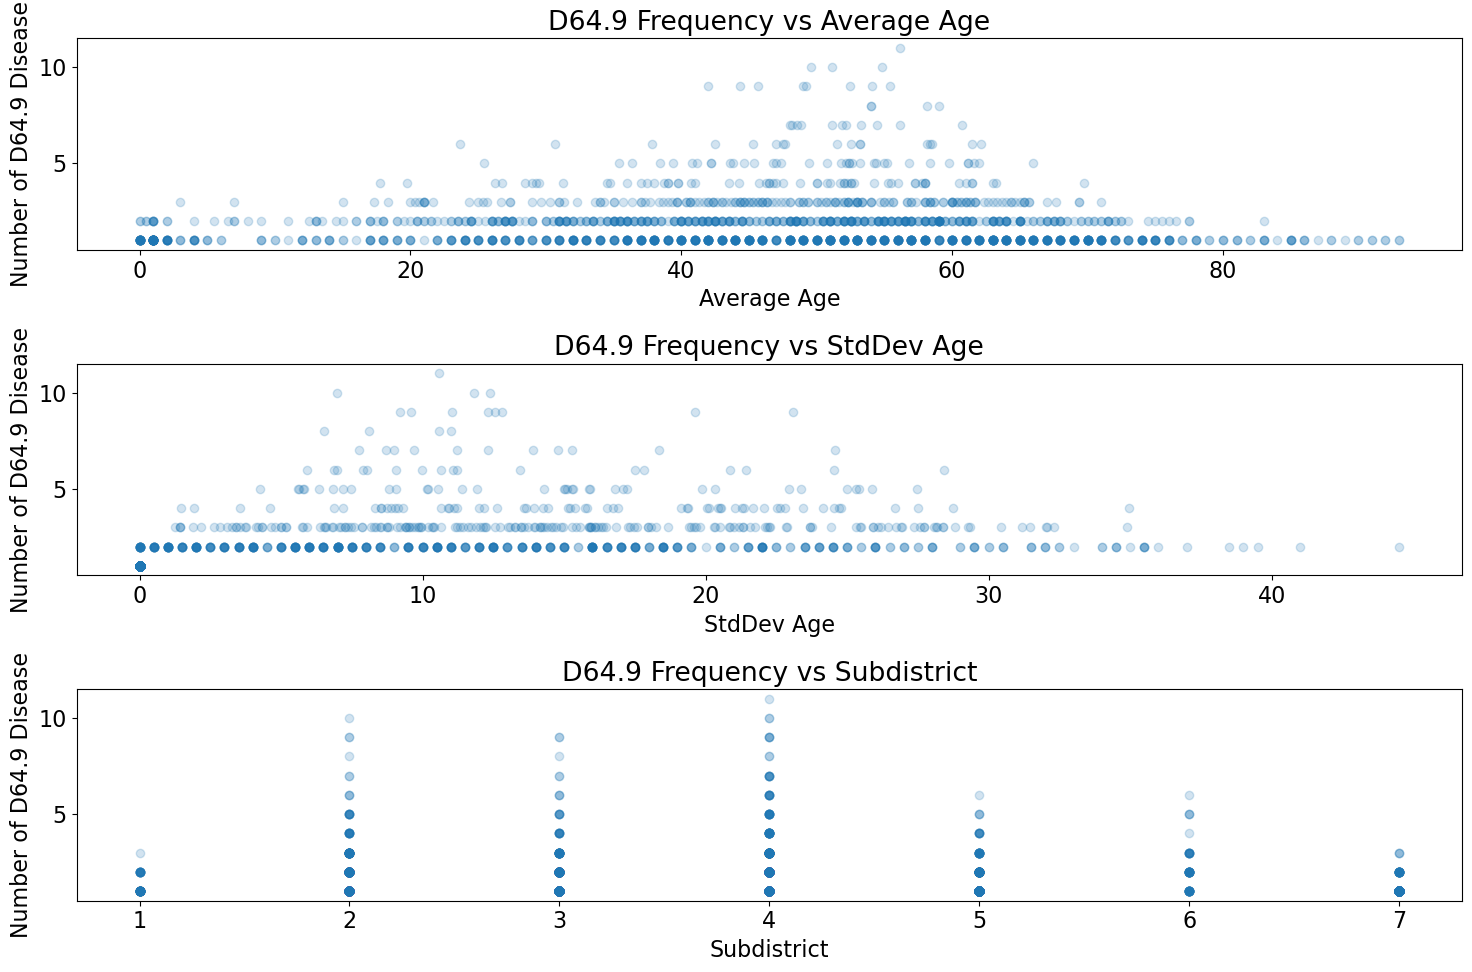

In [18]:
plot = df_D64.copy()
plot = plot.dropna(axis=1, how='all')  # Hapus kolom yang semua isinya NaN
plot = plot.dropna()

selected_columns = ['Average Age', 'StdDev Age', 'Subdistrict']
fig, axs = plt.subplots(3,1, figsize = (15,10), dpi=100)
axs = axs.ravel()

for i, column in enumerate(selected_columns):
    axs[i].scatter(plot[column], plot["Frequency"], alpha = 0.2)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Number of D64.9 Disease")
    axs[i].set_title('D64.9 Frequency vs {}'.format(column))
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [19]:
df_uji = df_D64.copy()
results = []

# uji spearman untuk fitur numerik
numeric_cols = ['Average Age', 'StdDev Age']
for col in numeric_cols:
    rs, p = spearmanr(df_uji[col], df_uji['Frequency'], nan_policy='omit')
    results.append({
        'Feature': col,
        'Test': 'Spearman',
        'Statistic': rs,
        'p_value': p
    })

# uji chi-square untuk fitur kategorikal: Subdistrict vs Frequency
df_uji['Frequency_bin'] = pd.qcut(df_uji['Frequency'], q=4, duplicates='drop') #variabel freq diubah dulu ke kategori (binned)

contingency = pd.crosstab(df_uji['Subdistrict'], df_uji['Frequency_bin'])
chi2, p, dof, expected = chi2_contingency(contingency)

results.append({
    'Feature': 'Subdistrict',
    'Test': 'Chi-Square',
    'Statistic': chi2,
    'p_value': p
})

corr_df = pd.DataFrame(results)
corr_df


,Feature,Test,Statistic,p_value
0,Average Age,Spearman,-0.030762,1.968183e-01
1,StdDev Age,Spearman,0.899214,0.000000e+00
2,Subdistrict,Chi-Square,119.821940,1.776129e-23


# 4. Exploratory Data Analysis

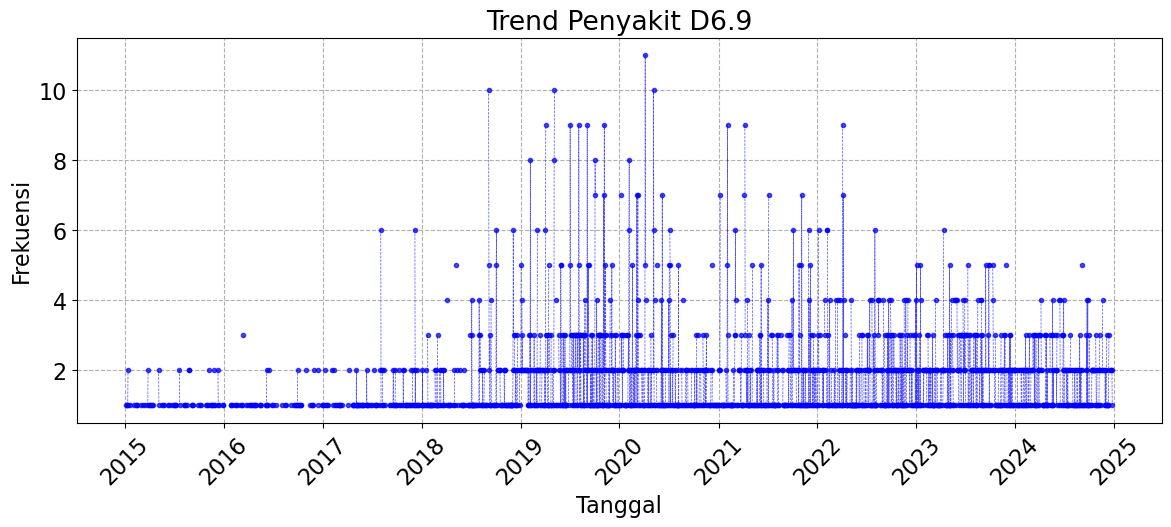

In [20]:
df = df_D64.copy() 

df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df.index, df["Frequency"], 
    marker="o", markersize=3, linestyle="dashed", 
    color="blue", alpha=0.7, linewidth=0.5)

plt.xticks(rotation=45)

ax.set_title("Trend Penyakit D6.9")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.grid(True, linestyle="--", alpha=1)

plt.show()

### Day Of Week

In [21]:
data_daily = df_D64.resample("D").sum()
data_daily.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-05,D64.9,1.0,57.0,0.0,1.0
2015-01-06,0,0.0,0.0,0.0,0.0
2015-01-07,0,0.0,0.0,0.0,0.0
2015-01-08,D64.9,1.0,2.0,0.0,6.0
2015-01-09,0,0.0,0.0,0.0,0.0


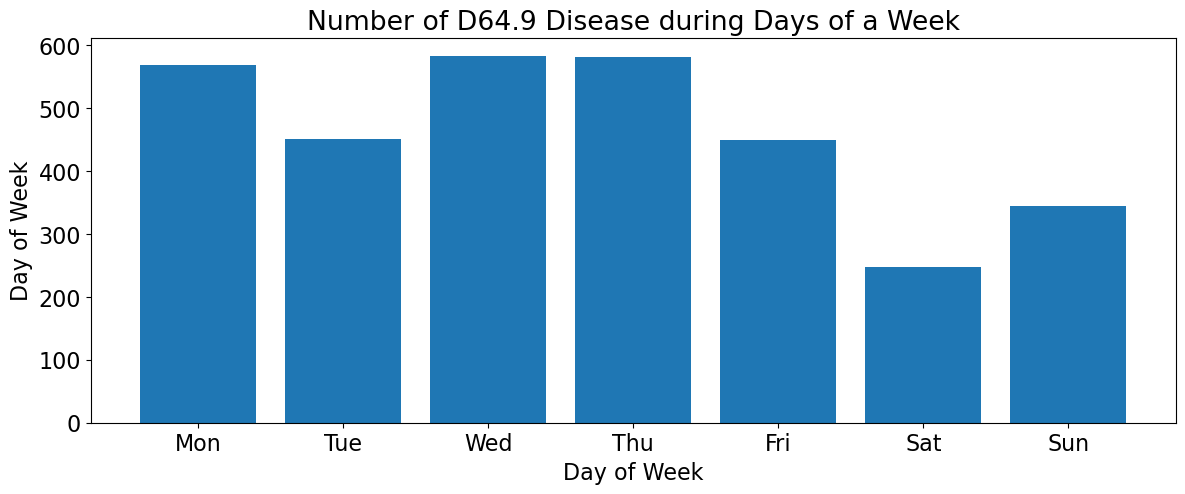

In [16]:
data_weekday = data_daily.groupby(data_daily.index.dayofweek).sum(numeric_only=True)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(data_weekday.index, data_weekday["Frequency"])
ax.set_xticks(range(7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_xlabel("Day of Week")
ax.set_ylabel("Day of Week")
ax.set_title("Number of D64.9 Disease during Days of a Week")
plt.show()

### 4.1 D64.9 Disease vs Avg Age

In [17]:
data_average = df_D64.groupby('Average Age')['Frequency'].sum()
data_average_flatten = []

for average_age, freq in zip(data_average.index.to_numpy(), data_average.values):
    for _ in range(int(freq)):
        data_average_flatten.append(average_age)
data_average_flatten = np.array(data_average_flatten)
data_average_flatten 

array([ 0.,  0.,  0., ..., 92., 93., 93.])

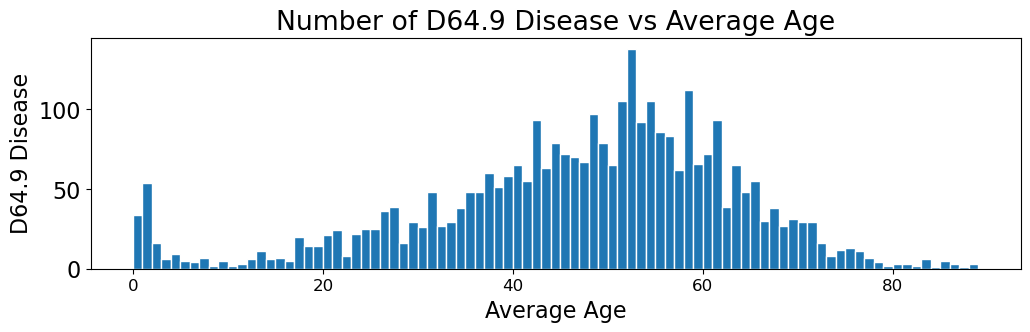

In [18]:
fig, ax = plt.subplots(figsize = (12,3))

bins = np.arange(0, 90)
ax.hist(data_average_flatten, bins=bins, edgecolor="white")
ax.set_xlabel('Average Age')
ax.set_ylabel('D64.9 Disease')
ax.set_title('Number of D64.9 Disease vs Average Age')

plt.xticks(fontsize=12)
plt.show()


### 4.2 D64.9 Disease vs Std Age

In [19]:
data_std = df_D64.groupby('StdDev Age')['Frequency'].sum()
data_std_flatten = []

for std_age, freq in zip(data_std.index.to_numpy(), data_std.values):
    for _ in range(int(freq)):
        data_std_flatten.append(std_age)
data_std_flatten = np.array(data_std_flatten)
data_std_flatten

array([ 0. ,  0. ,  0. , ..., 41. , 44.5, 44.5])

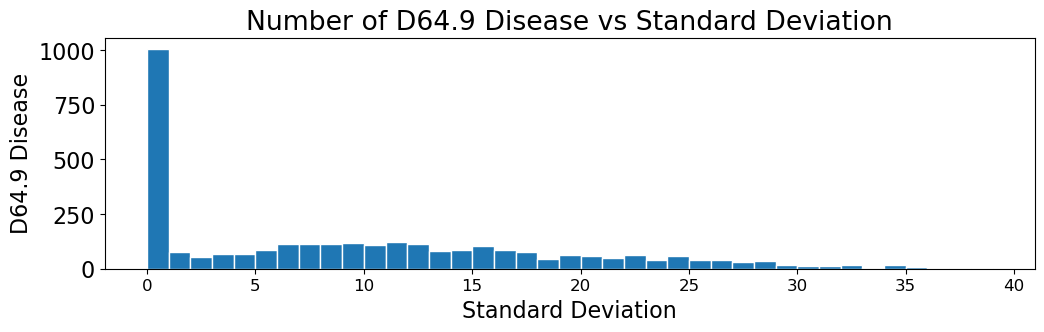

In [20]:
fig, ax = plt.subplots(figsize = (12,3))

bins = np.arange(0, 40)
ax.hist(data_std_flatten, bins=bins, edgecolor="white")
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('D64.9 Disease')
ax.set_title('Number of D64.9 Disease vs Standard Deviation')

plt.xticks(fontsize=12)
plt.show()


### 4.3 D64.9 Disease vs Subdistrict

- 1 = balikpapan timur
- 2 = balikpapan barat
- 3 = balikpapan utara
- 4 = balikpapan tengah
- 5 = balikpapan selatan
- 6 = balikpapan kota
- 99 = luar balikpapan

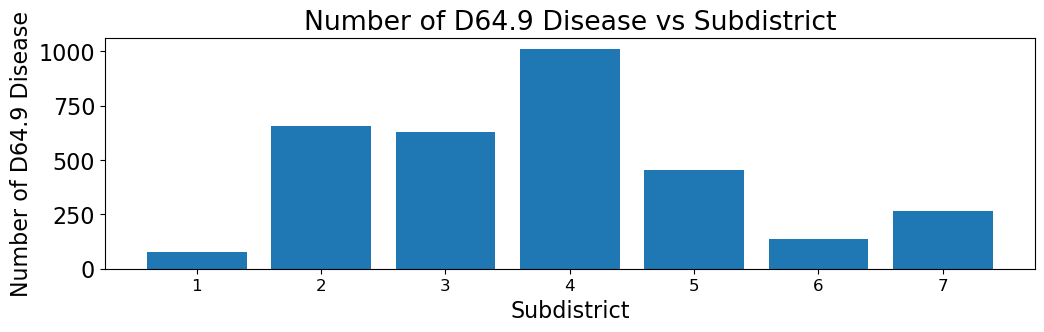

In [21]:
data_subdistrict = df_D64.groupby('Subdistrict')['Frequency'].sum()

fig, ax = plt.subplots(figsize = (12,3))

ax.bar(data_subdistrict.index, data_subdistrict.values)
ax.set_xlabel('Subdistrict')
ax.set_ylabel('Number of D64.9 Disease')
ax.set_title('Number of D64.9 Disease vs Subdistrict')

plt.xticks(fontsize=12)
plt.show()


## Time Series Component

##### 4.2.1 `D64.9` Disease Daily

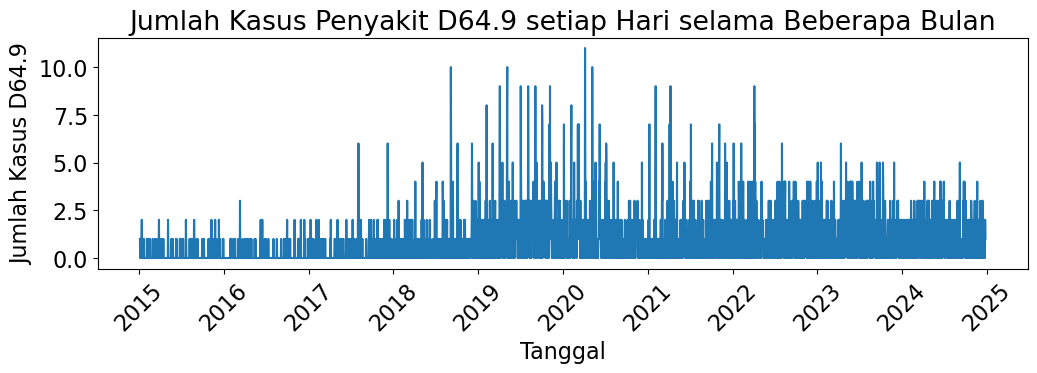

In [22]:
df_D64["Frequency"] = pd.to_numeric(df_D64["Frequency"], errors="coerce").fillna(0) 

data_daily_subset = df_D64.loc['2015-01-01':'2024-12-31']

# plot the daily counts
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(data_daily_subset.index, data_daily_subset['Frequency'])

ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus D64.9')
ax.set_title('Jumlah Kasus Penyakit D64.9 setiap Hari selama Beberapa Bulan')

ax.set_xticks(data_daily_subset.index[::30])  # Menampilkan label setiap 7 hari
ax.set_xticklabels(data_daily_subset.index[::30], rotation=45)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

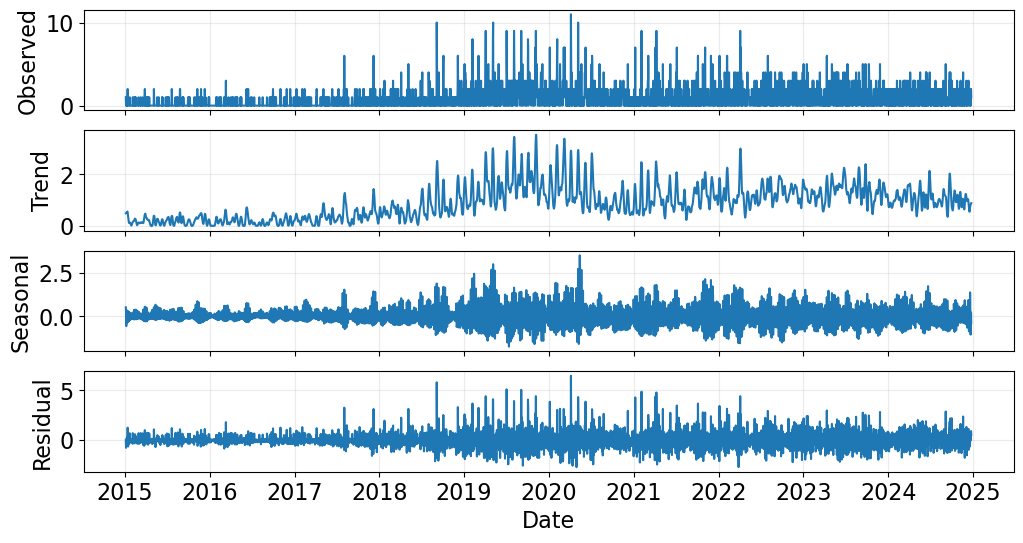

In [23]:
advanced_decomposition = STL(data_daily_subset["Frequency"], period=7).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)

axes[0].plot(data_daily_subset.index, advanced_decomposition.observed)
axes[1].plot(data_daily_subset.index, advanced_decomposition.trend)
axes[2].plot(data_daily_subset.index, advanced_decomposition.seasonal)
axes[3].plot(data_daily_subset.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

##### 4.2.2 `D64.9` Disease Weekly

In [24]:
# bikin dataframe baru yang mengubah frekuensi data menjadi mingguan
data_weekly = df_D64.resample("W").agg({
    "Disease": "first",
    "Frequency": "sum",
    "Average Age": "mean",
    "StdDev Age": "mean",
    "Subdistrict":"first"
})
data_weekly.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-11,D64.9,3.0,34.0,0.0,1.0
2015-01-18,D64.9,3.0,45.5,1.0,3.0
2015-01-25,D64.9,1.0,40.0,0.0,7.0
2015-02-01,None,0.0,NaN,NaN,NaN
2015-02-08,D64.9,1.0,57.0,0.0,1.0


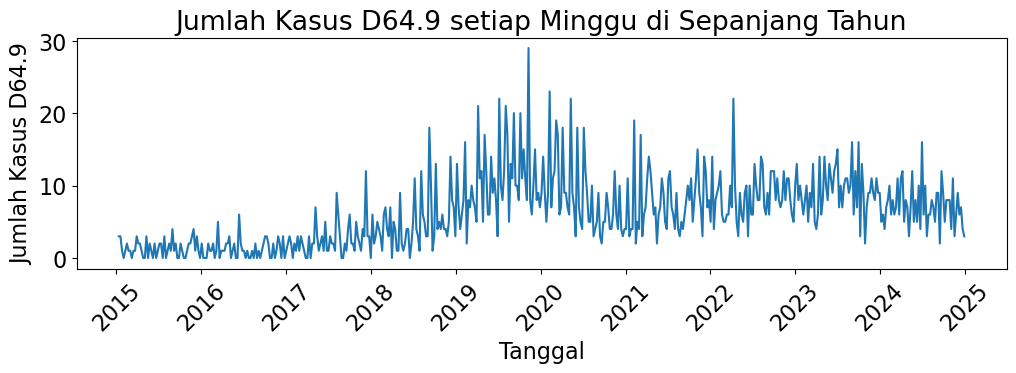

In [25]:
data_weekly_subset = data_weekly.loc['2015-01-01':'2024-12-31']

# plot the weekly counts
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(data_weekly_subset.index, data_weekly_subset['Frequency'])
ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus D64.9')
ax.set_title('Jumlah Kasus D64.9 setiap Minggu di Sepanjang Tahun')
# ax.set_xticks(data_weekly_subset.index[::2], rotation = 90)

ax.set_xticks(data_weekly_subset.index[::2])
ax.set_xticklabels(data_weekly_subset.index[::2], rotation=45)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

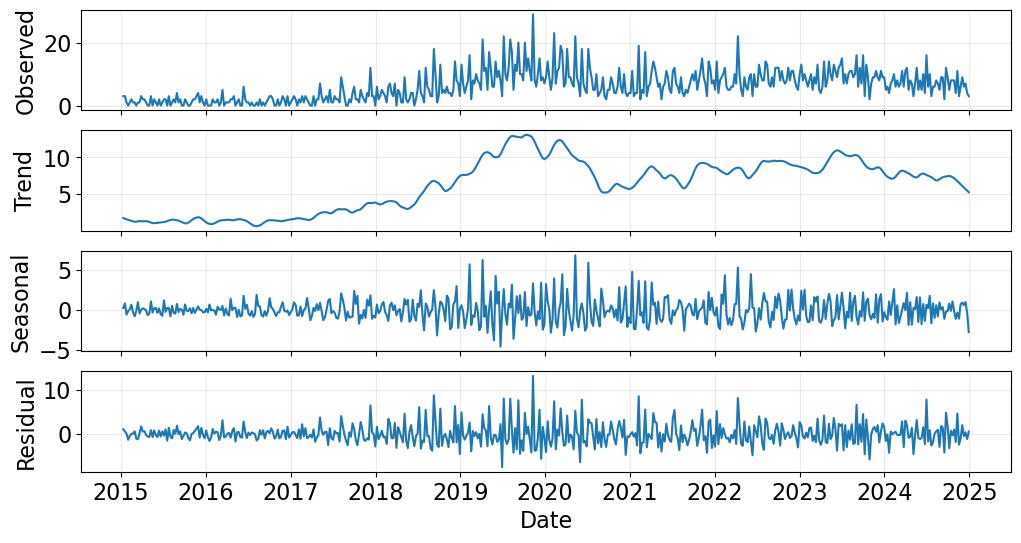

In [26]:
advanced_decomposition = STL(data_weekly_subset["Frequency"], period=8).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)

axes[0].plot(data_weekly_subset.index, advanced_decomposition.observed)
axes[1].plot(data_weekly_subset.index, advanced_decomposition.trend)
axes[2].plot(data_weekly_subset.index, advanced_decomposition.seasonal)
axes[3].plot(data_weekly_subset.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

##### 4.2.3 `D64.9` Disease Monthly

In [27]:
data_monthly = df_D64.resample("M").agg({
    "Disease" : "first",
    "Frequency": "sum",
    "Average Age": "mean",
    "StdDev Age": "mean",
    "Subdistrict":"first"
})
data_monthly.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-31,D64.9,7.0,38.833333,0.333333,1.0
2015-02-28,D64.9,4.0,45.750000,0.000000,1.0
2015-03-31,D64.9,6.0,36.600000,1.000000,3.0
2015-04-30,D64.9,5.0,36.400000,0.000000,5.0
2015-05-31,D64.9,6.0,53.700000,3.300000,5.0


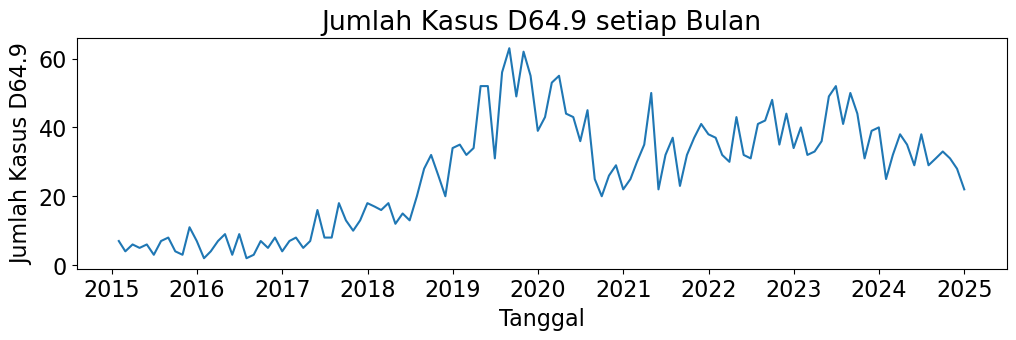

In [28]:
# plot the monthly counts
fig, ax = plt.subplots(figsize = (12,3))

ax.plot(data_monthly.index, data_monthly['Frequency'])

ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus D64.9')
ax.set_title('Jumlah Kasus D64.9 setiap Bulan')

xticks = data_monthly.index[::12]
ax.set_xticks(xticks)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

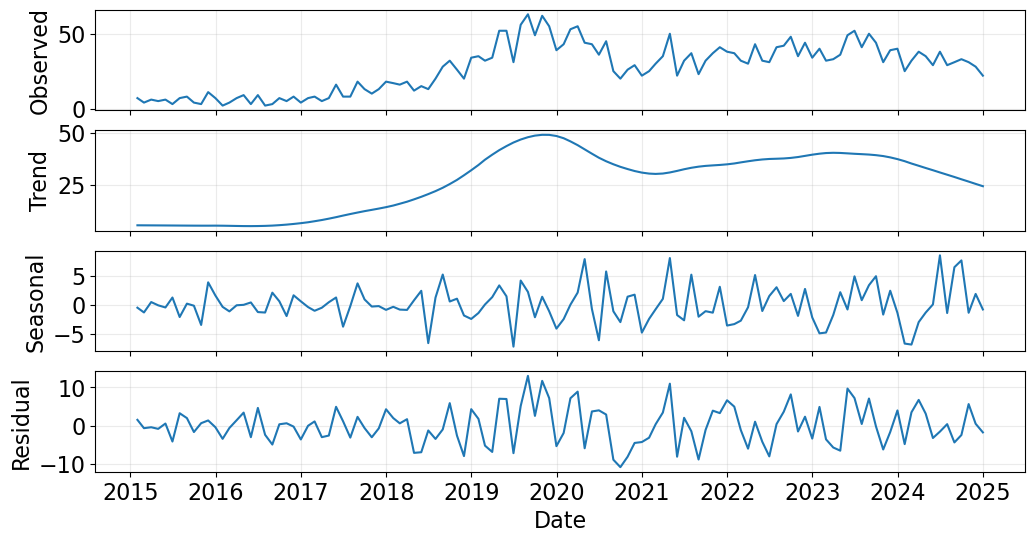

In [29]:
advanced_decomposition = STL(data_monthly["Frequency"], period=12).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)

axes[0].plot(data_monthly.index, advanced_decomposition.observed)
axes[1].plot(data_monthly.index, advanced_decomposition.trend)
axes[2].plot(data_monthly.index, advanced_decomposition.seasonal)
axes[3].plot(data_monthly.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

dalam interval bulanan, terjadi adanya tren naik di sepanjang pertengahan tahun, kemudian turun di akhir tahun.

- Proses Exploratory Data Analysis berguna untuk melihat pola pada data dalam waktu yang spesifik, yaitu daily, weekly, dan monthly.
- Hasil analisa dari tahap EDA digunakan untuk menentukan apakah perlu menggunakan metode statistik (mean, sum, median, std, quantile) sebelum masuk ke XGBoost Model.
- Hasil dari plot dekomposisi time series pada gambar yaitu terlihat adanya pola jangka panjang yang meningkat di awal kemudian sedikit menurun di akhir (tren). Serta, adanya pola musiman yang sangat jelas dengan periode harian, mingguan, atau tahunan (seasonal).
- Karena pola musiman sangat kuat, maka lag variables saja sudah cukup untuk menangkap pola ini tanpa harus menggunakan metode statistik.
- Metode statistik  sebaiknya dgunakan apabila ada pola mingguan yang berubah-ubah (misalnya, ada lonjakan di hari tertentu yang tidak konsisten).

# 5. Forecasting with XGBoost

## 5.1 Prepare the Data (Splitting Data)

In [30]:
def create_feature(data) :
    data = df_D64.copy()
    # data['Subdistrict'] = data['Subdistrict'].astype(int)
    data.index = pd.to_datetime(data.index) 

    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['day_of_year'] = data.index.dayofyear

    return data

def add_lags(data) : 
    
    # data = df_E11.copy()

    window_size = 7  # Rolling window 7 hari
    rolling_features = data[['Frequency']].rolling(window=window_size).agg(['sum', 'median', 'mean', 'std'])
    rolling_features.columns = [f'rolling_{col}' for col in ['sum', 'median', 'mean', 'std']]
    
    data = pd.concat([data, rolling_features], axis=1)
    
    lag_days = [7, 14] 
    diseases = ["Frequency"] 

    for disease in diseases:
        for lag in lag_days:
            data[f'{disease}_lag_{lag}'] = data[disease].shift(lag)

    return data

In [31]:
data = df_D64.copy()
data = add_lags(create_feature(data))
data

,Disease,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_median,rolling_mean,rolling_std,Frequency_lag_7,Frequency_lag_14
Date,,,,,,,,,,,,,,
2015-01-05,D64.9,1.0,57.0,0.0,1.0,0,1,5,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,0.0,NaN,NaN,NaN,1,1,6,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,0.0,NaN,NaN,NaN,2,1,7,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,D64.9,1.0,2.0,0.0,6.0,3,1,8,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,0.0,NaN,NaN,NaN,4,1,9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,D64.9,2.0,32.0,14.0,2.0,4,12,355,4.0,0.0,0.571429,0.975900,0.0,1.0
2024-12-21,NaN,0.0,NaN,NaN,NaN,5,12,356,4.0,0.0,0.571429,0.975900,0.0,0.0
2024-12-22,NaN,0.0,NaN,NaN,NaN,6,12,357,4.0,0.0,0.571429,0.975900,0.0,1.0


In [32]:
data.dtypes

Disease              object
Frequency           float64
Average Age         float64
StdDev Age          float64
Subdistrict         float64
day_of_week           int32
month                 int32
day_of_year           int32
rolling_sum         float64
rolling_median      float64
rolling_mean        float64
rolling_std         float64
Frequency_lag_7     float64
Frequency_lag_14    float64
dtype: object

# Splitting Data

In [33]:
# data['Subdistrict'] = data['Subdistrict'].astype(float)
data.fillna(0, inplace=True)

def split_dataset(data, train_percentage, valid_percentage, features):
    total_data = len(data)
    train_size = int(train_percentage* total_data)
    valid_size = int(valid_percentage * total_data)
    test_size = total_data - (train_size + valid_size)

    train_data = data.iloc[:train_size].copy()
    valid_data = data.iloc[train_size:train_size + valid_size].copy()
    test_data = data.iloc[train_size + valid_size:].copy()

    # split the data into features and target variable
    X_train = train_data[features]
    y_train = train_data["Frequency"]

    X_valid = valid_data[features]
    y_valid = valid_data["Frequency"]
    
    X_test = test_data[features]
    y_test = test_data["Frequency"]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [34]:
features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'month', 'day_of_year',
            'rolling_sum', 'rolling_median', 'rolling_mean', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14', ]

train_percentage = 0.8 # 80% Train
valid_percentage = 0.1  # 10% Validation
test_percentage = 0.1   # 10% Test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset(data, train_percentage, valid_percentage, features)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)  # Harus 12 fitur!
print("Shape of y_valid:", y_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2913, 12)
Shape of y_train: (2913,)
Shape of X_valid: (364, 12)
Shape of y_valid: (364,)
Shape of X_test: (365, 12)
Shape of y_test: (365,)


In [35]:
# cek rentang tanggal splitting data
date_range = pd.date_range(start="2015-01-01", end="2024-12-31")
split = pd.DataFrame({"Date": date_range})

train_size = 2913
valid_size = 364
test_size = 365

train_data = split.iloc[:train_size]
valid_data = split.iloc[train_size:train_size + valid_size]
test_data = split.iloc[train_size + valid_size:]

print(f"Train: {train_data.Date.iloc[0]} sampai {train_data.Date.iloc[-1]}")
print(f"Valid: {valid_data.Date.iloc[0]} sampai {valid_data.Date.iloc[-1]}")
print(f"Test: {test_data.Date.iloc[0]} sampai {test_data.Date.iloc[-1]}")

Train: 2015-01-01 00:00:00 sampai 2022-12-22 00:00:00
Valid: 2022-12-23 00:00:00 sampai 2023-12-21 00:00:00
Test: 2023-12-22 00:00:00 sampai 2024-12-31 00:00:00


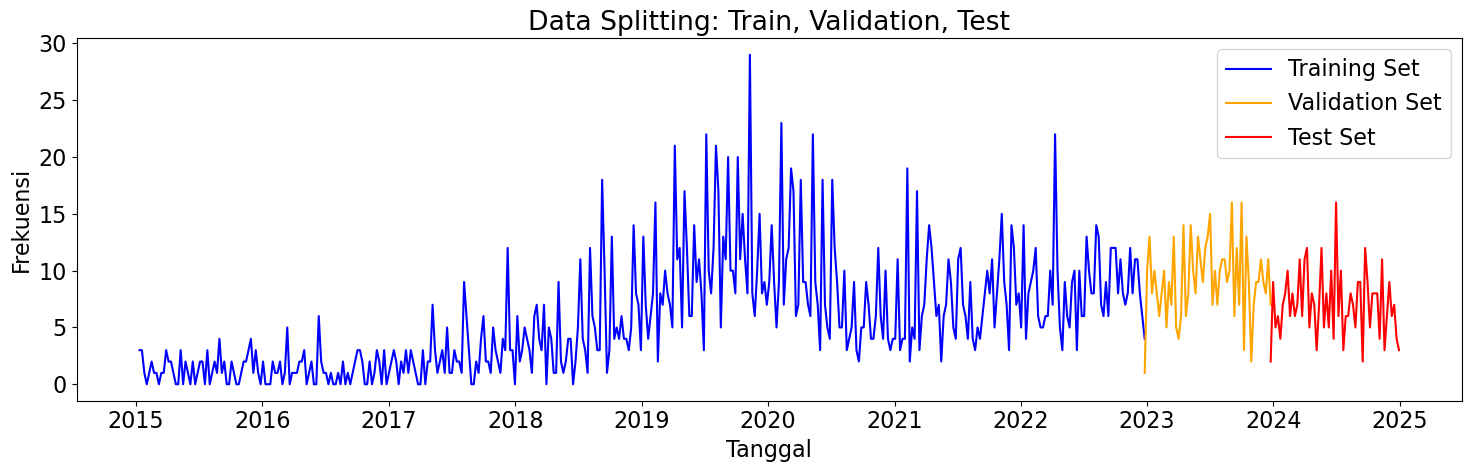

In [36]:
data.index = pd.to_datetime(data.index)

data['Frequency'] = pd.to_numeric(data['Frequency'], errors='coerce')

train_data = data.loc[:'2022-12-22']
valid_data = data.loc['2022-12-23':'2023-12-21']
test_data = data.loc['2023-12-22':]

# sampling data perminggu
train_weekly = train_data[['Frequency']].resample('W').sum()
valid_weekly = valid_data[['Frequency']].resample('W').sum()
test_weekly = test_data[['Frequency']].resample('W').sum()

fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
ax.plot(train_weekly.index, train_weekly['Frequency'], label='Training Set', color='blue')
ax.plot(valid_weekly.index, valid_weekly['Frequency'], label='Validation Set', color='orange')
ax.plot(test_weekly.index, test_weekly['Frequency'], label='Test Set', color='red')

ax.set_title("Data Splitting: Train, Validation, Test")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.legend()
plt.tight_layout()
plt.show()

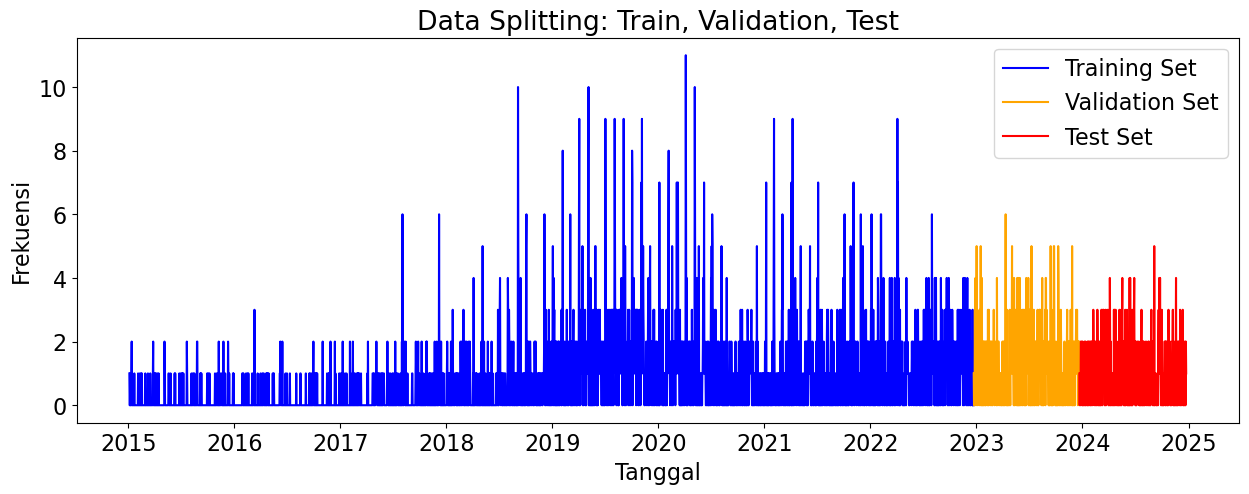

In [37]:
# plot splitting data
train_data = data.loc[:'2022-12-22']
valid_data = data.loc['2022-12-23':'2023-12-21']
test_data = data.loc['2023-12-22':]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(train_data.index, train_data['Frequency'], label='Training Set', color='blue')
ax.plot(valid_data.index, valid_data['Frequency'], label='Validation Set', color='orange')
ax.plot(test_data.index, test_data['Frequency'], label='Test Set', color='red')

ax.set_title("Data Splitting: Train, Validation, Test")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.legend()

plt.show()


In [38]:
data.describe()

,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_median,rolling_mean,rolling_std,Frequency_lag_7,Frequency_lag_14
count,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000
mean,0.885777,22.341112,2.998963,1.922845,2.998627,6.517847,183.003020,6.191653,0.639484,0.884522,0.957940,0.883855,0.882482
std,1.288455,26.627848,6.979706,2.295364,2.000617,3.441325,105.161511,4.862917,0.718118,0.694702,0.675463,1.288390,1.287945
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,92.000000,2.000000,0.000000,0.285714,0.487950,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000,7.000000,183.000000,5.000000,1.000000,0.714286,0.816497,0.000000,0.000000
75%,1.000000,48.000000,0.000000,4.000000,5.000000,10.000000,274.000000,9.000000,1.000000,1.285714,1.214986,1.000000,1.000000
max,11.000000,93.000000,44.500000,7.000000,6.000000,12.000000,366.000000,29.000000,4.000000,4.142857,4.259443,11.000000,11.000000


# 7. Define the XGBoost Model and Perform Hyperparameter Tuning

In [ ]:
baseline_model = xgb.XGBRegressor(
    tree_method="hist",
    objective="reg:squarederror",
    random_state=42
)
baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=3, ...)

# Feature Importance

In [40]:
feature_importance = pd.DataFrame(data=baseline_model.feature_importances_, index=baseline_model.feature_names_in_, columns=['importance'])
feature_importance

,importance
Average Age,0.027604
StdDev Age,0.415921
Subdistrict,0.251643
day_of_week,0.012504
month,0.007595
day_of_year,0.007982
rolling_sum,0.016203
rolling_median,0.060085
rolling_mean,0.000000
rolling_std,0.162574


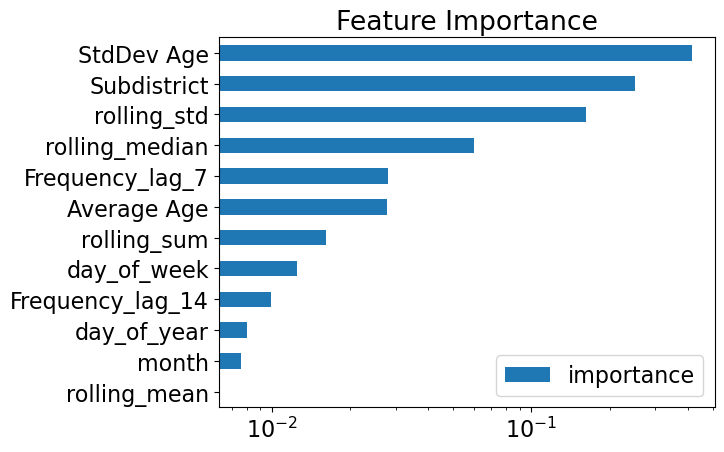

In [41]:
fig, ax = plt.subplots()
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax)
ax.set_xscale('log')
plt.show()

fitur `rolling_mean` dan `month` dibuang

In [42]:
y_pred = baseline_model.predict(X_valid)

nonzero_mask = y_valid != 0
if nonzero_mask.sum() > 0:
    mape = mean_absolute_percentage_error(y_valid[nonzero_mask], y_pred[nonzero_mask]) * 100
else:
    mape = float('inf')  

print(f"MAPE : {mape:.2f}%")

MAPE : 16.71%


In [42]:
top_features = feature_importance.sort_values(by='importance', ascending=False).head(11).index.tolist()

X_train_top = X_train[top_features]
X_valid_top = X_valid[top_features]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.01, 0.1]
}

tscv = TimeSeriesSplit(n_splits=3)

model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_top, y_train.to_numpy())
best_params = grid_search.best_params_
print("Best Parameters (Top 3 features):", best_params)

best_model = xgb.XGBRegressor(
    tree_method='hist',
    objective='reg:squarederror',
    early_stopping_rounds=20,
    random_state=42,
    **best_params
)

best_model.fit(
    X_train_top, y_train,
    eval_set=[(X_valid_top, y_valid)],
    verbose=True
)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters (Top 3 features): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
[0]	validation_0-rmse:1.32869
[1]	validation_0-rmse:1.26674
[2]	validation_0-rmse:1.21318
[3]	validation_0-rmse:1.16286
[4]	validation_0-rmse:1.11369
[5]	validation_0-rmse:1.06891
[6]	validation_0-rmse:1.02464
[7]	validation_0-rmse:0.98520
[8]	validation_0-rmse:0.95040
[9]	validation_0-rmse:0.91618
[10]	validation_0-rmse:0.88201
[11]	validation_0-rmse:0.85188
[12]	validation_0-rmse:0.82377
[13]	validation_0-rmse:0.79581
[14]	validation_0-rmse:0.77221
[15]	validation_0-rmse:0.74887
[16]	validation_0-rmse:0.72738
[17]	validation_0-rmse:0.70770
[18]	validation_0-rmse:0.69046
[19]	validation_0-rmse:0.67392
[20]	validation_0-rmse:0.65878
[21]	validation_0-rmse:0.64373
[22]	validation_0-rmse:0.63080
[23]	validation_0-rmse:0.61799
[24]	validation_0-rmse:0.60699
[25]	validation_0-rmse:0.59606
[26]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
data.describe()

,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_median,rolling_mean,rolling_std,Frequency_lag_7,Frequency_lag_14
count,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000
mean,0.885777,22.341112,2.998963,1.922845,2.998627,6.517847,183.003020,6.191653,0.639484,0.884522,0.957940,0.883855,0.882482
std,1.288455,26.627848,6.979706,2.295364,2.000617,3.441325,105.161511,4.862917,0.718118,0.694702,0.675463,1.288390,1.287945
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,92.000000,2.000000,0.000000,0.285714,0.487950,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,3.000000,7.000000,183.000000,5.000000,1.000000,0.714286,0.816497,0.000000,0.000000
75%,1.000000,48.000000,0.000000,4.000000,5.000000,10.000000,274.000000,9.000000,1.000000,1.285714,1.214986,1.000000,1.000000
max,11.000000,93.000000,44.500000,7.000000,6.000000,12.000000,366.000000,29.000000,4.000000,4.142857,4.259443,11.000000,11.000000


# 8. Train Using Time Series Walk Forward Validation

In [44]:
features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month',
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14']

train_end = "2022-12-22"  # Hari terakhir training
valid_start = "2022-12-23"
valid_end = "2023-12-21"
test_start = "2023-12-22"
test_end = "2024-12-31"

test_window = 14  # 2 minggu

all_predictions = pd.DataFrame(columns=["Actual_Frequency", "Predicted_Frequency"])
mape_scores = []

test_data = data.loc[test_start:test_end].copy()

# walk forward validation
for i in range(0, len(test_data) - test_window + 1, test_window):

    test = test_data.iloc[i:i+test_window]
    
    train_data = data.loc[:train_end].copy()
    valid_data = data.loc[valid_start:valid_end].copy()

    X_train = train_data[features]
    y_train = train_data['Frequency']
    
    X_valid = valid_data[features]
    y_valid = valid_data['Frequency']
    
    X_test = test[features]
    y_test = test['Frequency']
    
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # meramalkan data
    y_pred = best_model.predict(X_test)

    temp_df = pd.DataFrame({
        "Actual_Frequency": y_test.values,
        "Predicted_Frequency": y_pred
    }, index=y_test.index)
    
    all_predictions = pd.concat([all_predictions, temp_df])
    train_data = pd.concat([train_data, test])


In [45]:
all_predictions.head()

,Actual_Frequency,Predicted_Frequency
2023-12-22,1.0,1.010478
2023-12-23,0.0,0.012048
2023-12-24,1.0,1.012534
2023-12-25,1.0,1.042141
2023-12-26,0.0,0.012048


In [46]:
total_aktual = all_predictions["Actual_Frequency"].sum()
total_prediksi = all_predictions["Predicted_Frequency"].sum()
total_prediksi = np.ceil(total_prediksi)

print(f"Total Aktual: {total_aktual}")
print(f"Total Prediksi: {total_prediksi}")

Total Aktual: 377.0
Total Prediksi: 376.0


In [47]:
all_predictions.index = pd.to_datetime(all_predictions.index)
all_predictions['bulan'] = all_predictions.index.to_period('M')

monthly_sum = all_predictions.groupby('bulan').sum()
monthly_sum['Predicted_Frequency'] = np.ceil(monthly_sum['Predicted_Frequency'])

print(monthly_sum)

         Actual_Frequency  Predicted_Frequency
bulan                                         
2023-12              11.0                 12.0
2024-01              25.0                 25.0
2024-02              32.0                 33.0
2024-03              38.0                 38.0
2024-04              35.0                 37.0
2024-05              29.0                 28.0
2024-06              38.0                 37.0
2024-07              29.0                 31.0
2024-08              31.0                 32.0
2024-09              33.0                 31.0
2024-10              31.0                 33.0
2024-11              28.0                 29.0
2024-12              17.0                 16.0


## 8.1 Plot the Results (After Validation)

In [45]:
# evaluasi MAPE (hindairn 0 supaya tidak error/infinity)
nonzero_mask = y_test != 0
if nonzero_mask.sum() > 0:
    mape = mean_absolute_percentage_error(y_test[nonzero_mask], y_pred[nonzero_mask]) * 100
else:
    mape = float('inf')  

print(f"MAPE: {mape:.2f}%")

MAPE: 4.65%


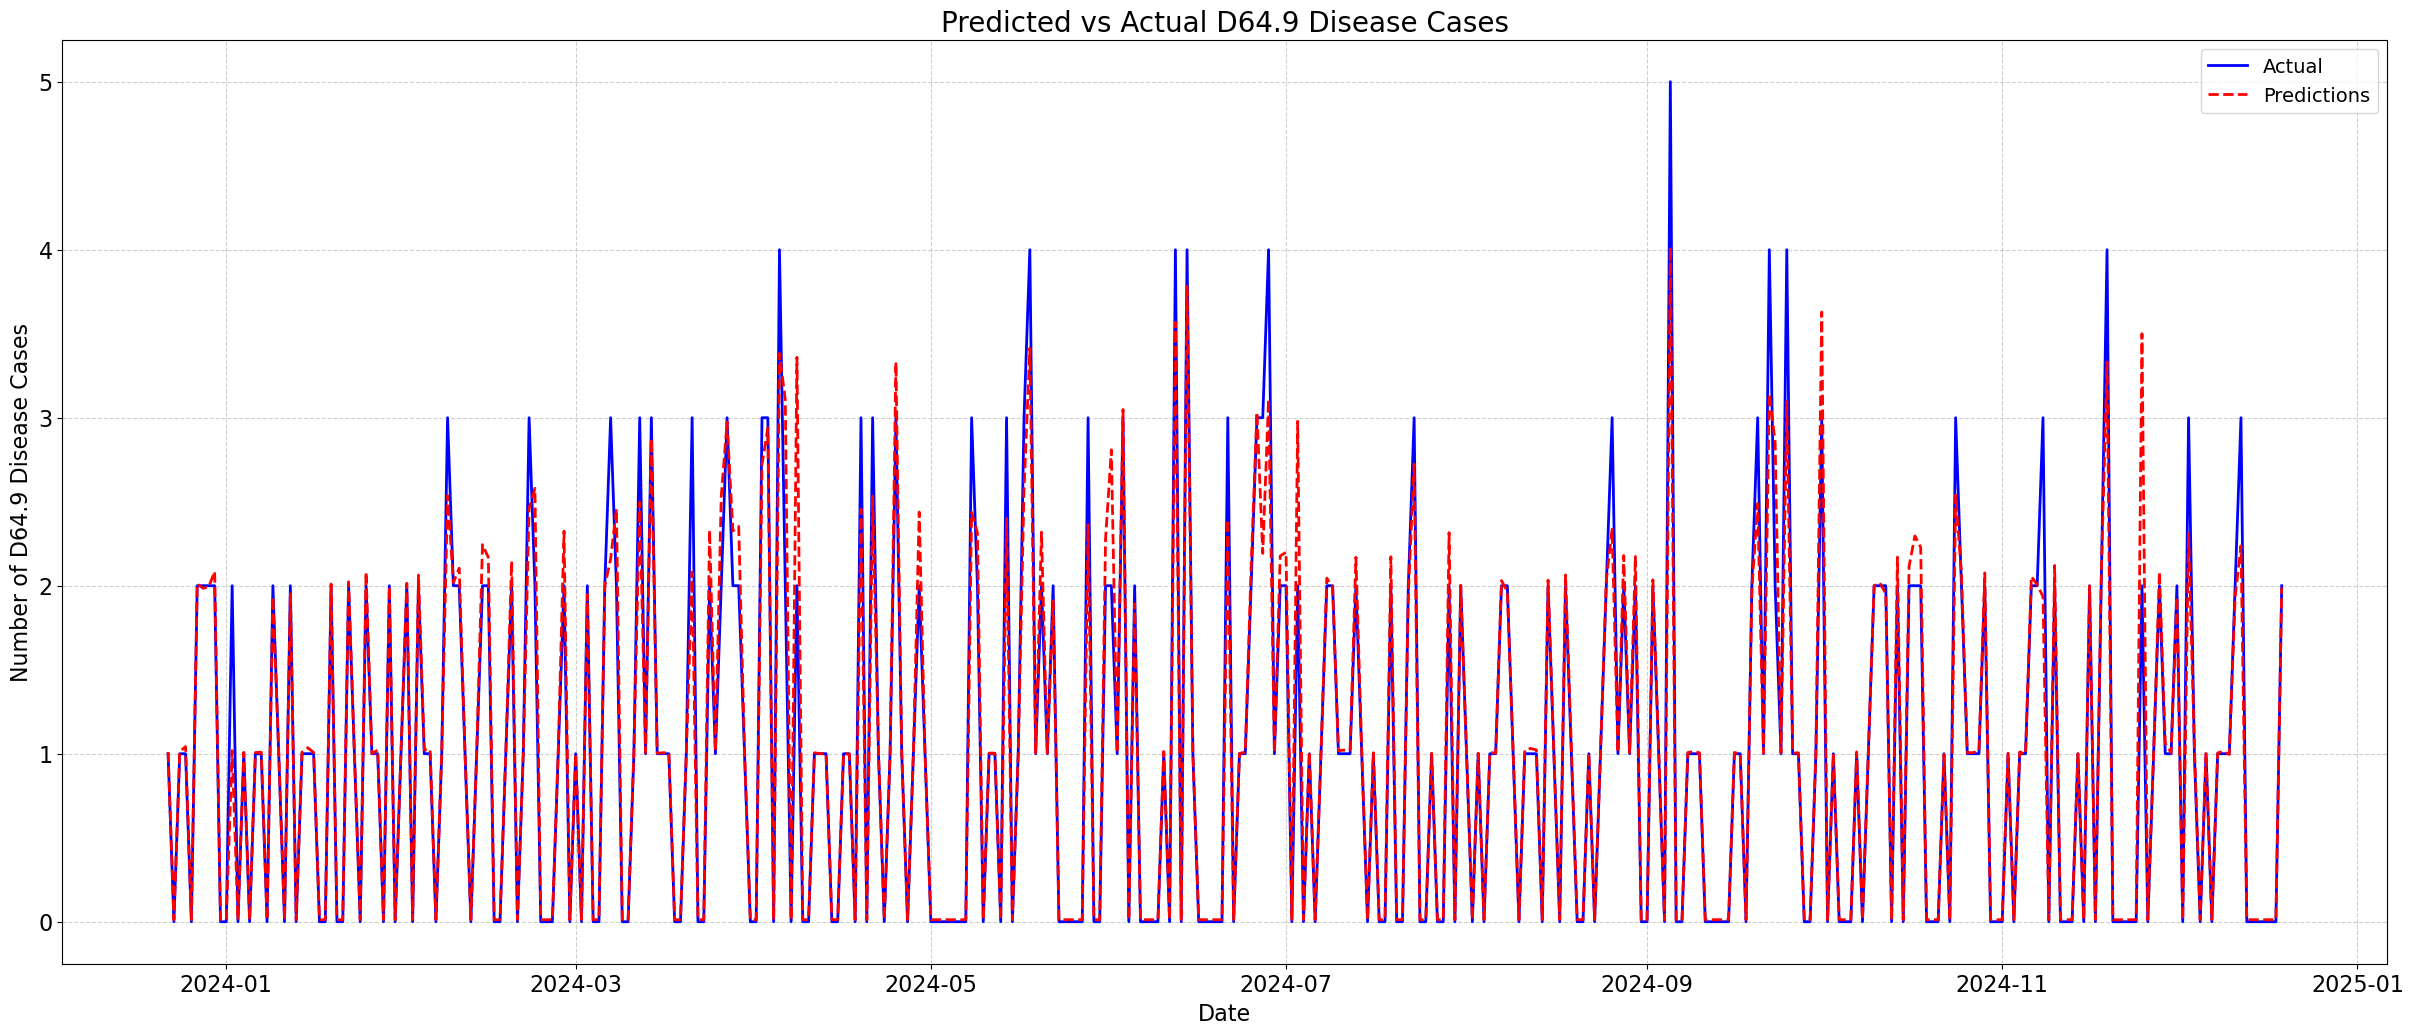

In [65]:
fig, ax = plt.subplots(figsize=(30, 12), dpi=100)

ax.plot(all_predictions.index, all_predictions["Actual_Frequency"], label="Actual", color="blue", linewidth=2)

ax.plot(all_predictions.index, all_predictions["Predicted_Frequency"], label="Predictions", color="red", linestyle="dashed", linewidth=2)

ax.set_ylabel("Number of D64.9 Disease Cases")
ax.set_xlabel("Date")
ax.set_title("Predicted vs Actual D64.9 Disease Cases", fontsize=20)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=14)

plt.show()

In [ ]:
all_predictions.index = pd.to_datetime(all_predictions.index, errors="coerce")
all_predictions.to_csv("all_predictions_D64_disease.csv", index=True)

# 9. Preparing to Predict the Future

In [48]:
predict = data.copy()

FEATURES = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month', 
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14', ]

TARGET = 'Frequency'

X_all = predict[FEATURES]
y_all = predict[TARGET]

best_model = xgb.XGBRegressor(
    tree_method='hist', 
    objective='reg:squarederror',
    early_stopping_rounds=10,
    **best_params
)

# Retrain menggunakan seluruh dataset sebelum prediksi masa depan
best_model.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:1.23173
[100]	validation_0-rmse:0.24762
[199]	validation_0-rmse:0.18727


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [49]:
predict.index.max()

Timestamp('2024-12-24 00:00:00')

In [50]:
predict.index = pd.to_datetime(predict.index)

In [51]:
future = pd.date_range('2024-12-24', '2025-05-31', freq='D')
future_df = pd.DataFrame(index=future)

future_df = future_df.reindex(columns=predict.columns, fill_value=np.nan)

future_df['isFuture'] = True
predict['isFuture'] = False
df_and_future = pd.concat([predict, future_df])

In [52]:
future_with_features = df_and_future[df_and_future['isFuture']].copy()


In [53]:
future_with_features.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_median,rolling_mean,rolling_std,Frequency_lag_7,Frequency_lag_14,isFuture
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [54]:
predict.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3642 entries, 2015-01-05 to 2024-12-24
Freq: D
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Disease           3642 non-null   object 
 1   Frequency         3642 non-null   float64
 2   Average Age       3642 non-null   float64
 3   StdDev Age        3642 non-null   float64
 4   Subdistrict       3642 non-null   float64
 5   day_of_week       3642 non-null   int32  
 6   month             3642 non-null   int32  
 7   day_of_year       3642 non-null   int32  
 8   rolling_sum       3642 non-null   float64
 9   rolling_median    3642 non-null   float64
 10  rolling_mean      3642 non-null   float64
 11  rolling_std       3642 non-null   float64
 12  Frequency_lag_7   3642 non-null   float64
 13  Frequency_lag_14  3642 non-null   float64
 14  isFuture          3642 non-null   bool   
dtypes: bool(1), float64(10), int32(3), object(1)
memory usage: 516.

# 11. Predict the Future

In [55]:
future_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2024-12-24 to 2025-05-31
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Disease           0 non-null      object 
 1   Frequency         0 non-null      float64
 2   Average Age       0 non-null      float64
 3   StdDev Age        0 non-null      float64
 4   Subdistrict       0 non-null      float64
 5   day_of_week       0 non-null      float64
 6   month             0 non-null      float64
 7   day_of_year       0 non-null      float64
 8   rolling_sum       0 non-null      float64
 9   rolling_median    0 non-null      float64
 10  rolling_mean      0 non-null      float64
 11  rolling_std       0 non-null      float64
 12  Frequency_lag_7   0 non-null      float64
 13  Frequency_lag_14  0 non-null      float64
 14  isFuture          159 non-null    bool   
dtypes: bool(1), float64(13), object(1)
memory usage: 18.8+ KB


In [56]:
def forecasting(future_with_features, best_model):
    features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month',
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14', ]
    
    future_with_features = future_with_features.copy()
    
    for i in range(len(future_with_features)):
        input_features = future_with_features.loc[future_with_features.index[i], features].values.reshape(1, -1)
        
        predicted_value = best_model.predict(input_features)[0]  
        # predicted_value = int(round(predicted_value))  
        
        future_with_features.at[future_with_features.index[i], 'Frequency'] = predicted_value
        
        if i + 7 < len(future_with_features):
            future_with_features.at[future_with_features.index[i + 7], 'Frequency_lag_7'] = predicted_value
        if i + 14 < len(future_with_features):
            future_with_features.at[future_with_features.index[i + 14], 'Frequency_lag_14'] = predicted_value
            
        if i >= 7:
            window_data = future_with_features['Frequency'].iloc[:i+1].rolling(7)
            future_with_features.at[future_with_features.index[i], 'rolling_median'] = window_data.median().iloc[-1]
            future_with_features.at[future_with_features.index[i], 'rolling_std'] = window_data.std().iloc[-1]

    return future_with_features


In [57]:
future_with_predictions = forecasting(future_with_features, best_model)

print(future_with_predictions[['Frequency']].head(30))

            Frequency
2024-12-24   4.174747
2024-12-25   4.174747
2024-12-26   4.174747
2024-12-27   4.174747
2024-12-28   4.174747
2024-12-29   4.174747
2024-12-30   4.174747
2024-12-31   4.203246
2025-01-01   4.203246
2025-01-02   4.203246
2025-01-03   4.203246
2025-01-04   4.203246
2025-01-05   4.203246
2025-01-06   4.203246
2025-01-07   3.992293
2025-01-08   3.992293
2025-01-09   3.992293
2025-01-10   3.992293
2025-01-11   3.992293
2025-01-12   3.992293
2025-01-13   3.992293
2025-01-14   4.518407
2025-01-15   4.518407
2025-01-16   4.518407
2025-01-17   4.518407
2025-01-18   4.518407
2025-01-19   4.518407
2025-01-20   4.518407
2025-01-21   3.997947
2025-01-22   3.997947


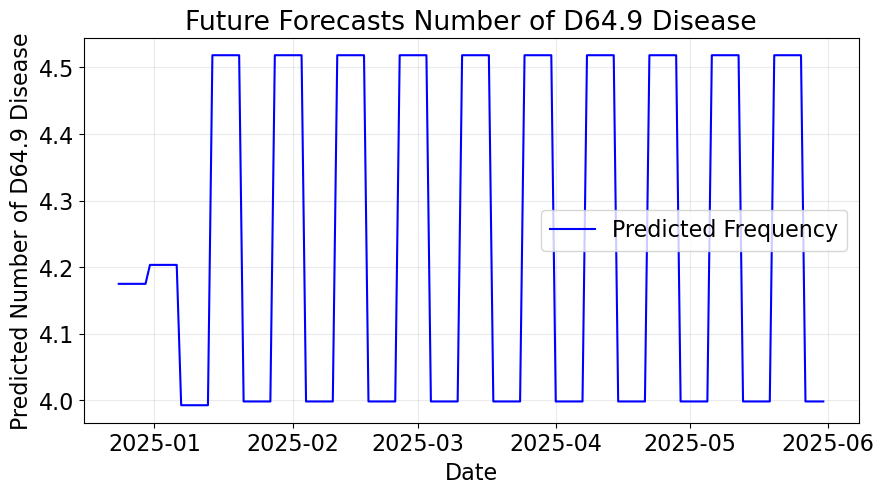

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(future_with_predictions.index, future_with_predictions['Frequency'], label='Predicted Frequency', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Number of D64.9 Disease')
ax.set_title('Future Forecasts Number of D64.9 Disease')
ax.legend()
ax.grid()

plt.show()

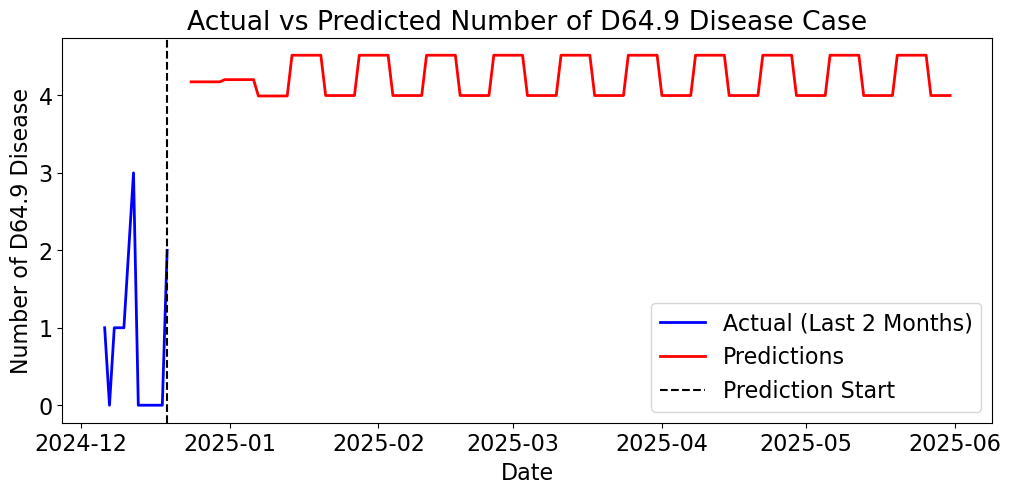

In [59]:
last_2_months_actual = y_test.last("2M")

future_dates = future_with_predictions.index
future_values = future_with_predictions['Frequency']

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(last_2_months_actual.index, last_2_months_actual, label = "Actual (Last 2 Months)", color="blue", linewidth=2)
ax.plot(future_dates, future_values, label="Predictions", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Number of D64.9 Disease")
ax.set_title("Actual vs Predicted Number of D64.9 Disease Case")
ax.axvline(x=last_2_months_actual.index[-1], color="black", linestyle="--", label="Prediction Start")
ax.legend()

plt.show()

In [60]:
future_with_predictions.index = pd.to_datetime(future_with_predictions.index)
monthly_predictions = future_with_predictions.resample('M').sum()
monthly_predictions['Frequency'] = np.ceil(monthly_predictions['Frequency'])

monthly_predictions["Frequency"]

2024-12-31     34.0
2025-01-31    131.0
2025-02-28    120.0
2025-03-31    133.0
2025-04-30    128.0
2025-05-31    132.0
Freq: M, Name: Frequency, dtype: float64

In [61]:
monthly_predictions["Frequency"].sum()

678.0

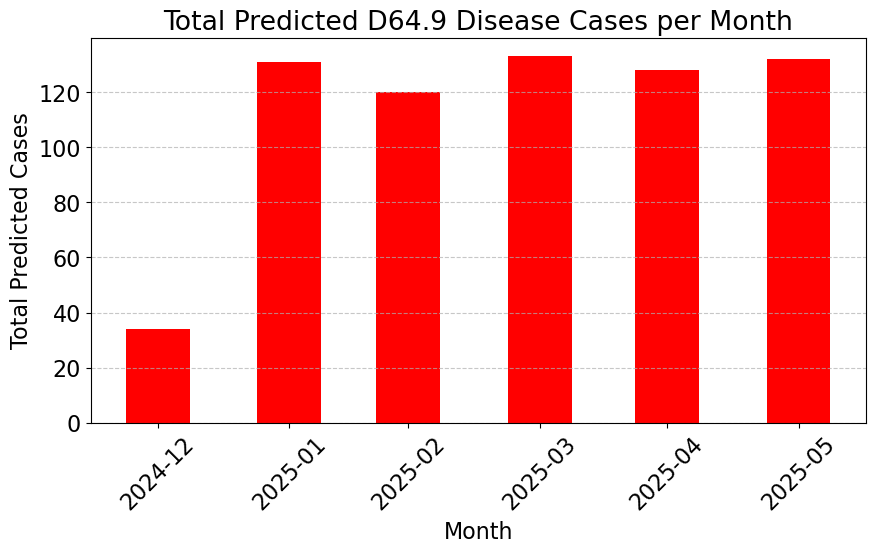

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(monthly_predictions.index, 
       monthly_predictions['Frequency'], 
       color='red', 
       label='Predicted Cases', 
       width=15)  

ax.set_xlabel('Month')
ax.set_ylabel('Total Predicted Cases')
ax.set_title('Total Predicted D64.9 Disease Cases per Month')
ax.set_xticks(monthly_predictions.index)
ax.set_xticklabels(monthly_predictions.index.strftime('%Y-%m'), rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# future_with_predictions[["Frequency"]].to_csv('predicted_D64_disease.csv', index=True)